### Code

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd.functional import hessian
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
%matplotlib inline

In [2]:
def plot_results(N, net, analytic_solution, path_to_images, lim_x, lim_y, lim_z_low, iteration, losses, angle=40,
                 create_gif=True):
    x_p = np.linspace(0, lim_x, N).astype(np.float32)
    z_p = np.linspace(0, lim_y, N).astype(np.float32)
    surface_an = np.zeros((N, N))
    for i, x in enumerate(x_p):
        for j, y in enumerate(z_p):
            surface_an[j][i] = analytic_solution([x, y])

    fig = plt.figure(figsize=(14, 16))
    ax = fig.add_subplot(2, 2, 1, projection='3d')
    X, Y = np.meshgrid(x_p, z_p)
    surf = ax.plot_surface(X, Y, surface_an, rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)
    ax.view_init(30, angle)
    ax.set_title('Аналитическое решение', fontsize=25)
    ax.set_xlim(0, lim_x)
    ax.set_ylim(0, lim_y)
    ax.set_zlim(lim_z_low, 1.5)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    input = torch.tensor(np.dstack(np.meshgrid(x_p, z_p)).flatten())
    neural_solution = net.calc_ans(input)

    surface_neural = np.zeros((N, N))
    k = 0
    for i, x in enumerate(x_p):
        for j, y in enumerate(z_p):
            surface_neural[i][j] = neural_solution[k]
            k += 1

    ax = fig.add_subplot(2, 2, 2, projection='3d')
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(x_p, z_p)
    surf = ax.plot_surface(X, Y, surface_neural, rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)
    ax.view_init(30, angle)
    
    ax.set_title('Нейросеть', fontsize=25)
    ax.set_xlim(0, lim_x)
    ax.set_ylim(0, lim_y)
    ax.set_zlim(lim_z_low, 1.5)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')


    ax3 = fig.add_subplot(2, 2, 3)
    ax3.plot(losses, label='Сум.квадр. ошибка по всем точкам сетки')
    plt.legend(fontsize=10)
    plt.xlabel('Число эпох', fontsize=15)
    ax3.set_title('Сум.квадр. ошибка по всем точкам сетки', fontsize=15)
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.set_title('Абс. отклонение в каждой точке сетки', fontsize=15)
    for_heatmap = np.abs(surface_neural - surface_an)
    sns.heatmap(for_heatmap, ax=ax4)

    plt.show()

    
    if create_gif:
      if not os.path.exists(path_to_images):
        os.makedirs(path_to_images)
      fig.savefig(path_to_images + '/' + '{:04d}.png'.format(iteration))
    return
    #return fig
    #return for_heatmap

In [3]:
############# 2 -> 10 -> 1 ДЛЯ A_22
class NetSimpleGrad(nn.Module):
    def __init__(self, N, psy_trial, A, hidden_size=20, lim_x=1, lim_y=1):
      super(NetSimpleGrad, self).__init__()
      self.fc1 = nn.Linear(2, hidden_size, bias=True)
      self.fc2 = nn.Linear(hidden_size, 1, bias=False)
      self.psy_trial = psy_trial
      self.A = A
      self.lim_x = lim_x
      self.lim_y = lim_y

    def calc_ans(self, x):
      ans = []
      for x_y in x.reshape(-1, 2):
        net_out = self.fc2(torch.sigmoid(self.fc1(x_y)))
        ans.append(self.psy_trial(x_y, net_out).item())
      return ans

    def forward(self, x):
      accumulated_hess = torch.zeros(1, requires_grad=True)
      for x_y in x.reshape(-1, 2):
        net_out = self.fc2(torch.sigmoid(self.fc1(x_y)))
        sigma_z = torch.sigmoid(self.fc1(x_y))

        dnet_out_dx = self.fc2(sigma_z * (1 - sigma_z) * self.fc1.weight[:, 0])
        dnet_out_dy = self.fc2(sigma_z * (1 - sigma_z) * self.fc1.weight[:, 1]) 

        dnet_out_dx2 = self.fc2(sigma_z * (1 - sigma_z) * (1 - sigma_z) * self.fc1.weight[:, 0] ** 2 + sigma_z * (-sigma_z) * (1 - sigma_z) * self.fc1.weight[:, 0] ** 2)
        dnet_out_dy2 = self.fc2(sigma_z * (1 - sigma_z) * (1 - sigma_z) * self.fc1.weight[:, 1] ** 2 + sigma_z * (-sigma_z) * (1 - sigma_z) * self.fc1.weight[:, 1] ** 2)

        hess_A = hessian(self.A, x_y, create_graph=True)
        dA_dx2 = hess_A[0][0]
        dA_dy2 = hess_A[1][1]
       
        dpsy_trial_dx2 = (x_y[1] - self.lim_y) * x_y[1] * ((x_y[0] ** 2 - self.lim_x * x_y[0]) * dnet_out_dx2 + (4 * x_y[0] - 2 * self.lim_x) * dnet_out_dx + 2 * net_out) + dA_dx2
        dpsy_trial_dy2 = (x_y[0] - self.lim_x) * x_y[0] * ((x_y[1] ** 2 - self.lim_y * x_y[1]) * dnet_out_dy2 + (4 * x_y[1] - 2 * self.lim_y) * dnet_out_dy + 2 * net_out) + dA_dy2


        hess_x_y = (dpsy_trial_dx2 + dpsy_trial_dy2) ** 2
        accumulated_hess = accumulated_hess + hess_x_y
      return accumulated_hess

In [4]:
from tqdm.notebook import tqdm
from IPython.display import clear_output
import seaborn as sns
import imageio
import os

def train(which_net, N, lr, num_epoch, psy_trial, A, analytic_solution, path_to_images,
          lim_x=1, lim_y=1, lim_z_low=-1, 
          hidden_size=20, init_weights=False, use_schedule=False, schedule_ep=100, schedule_gamma=0.5, 
          optimizer_type='adamw', angle=40,
          create_gif=True, fps=10):  
  net = which_net(N=N, psy_trial = psy_trial, A=A, hidden_size=hidden_size, lim_x=lim_x, lim_y=lim_y)
  
  def weights_init_uniform_rule(m):
    classname = m.__class__.__name__

    if classname.find('Linear') != -1:
      
      n = m.in_features
      y = 1.0/np.sqrt(n)
      m.weight.data.uniform_(-y, y)
      if m.bias is not None:
        m.bias.data.fill_(0)
  if init_weights:
    net.apply(weights_init_uniform_rule)           

  if optimizer_type == 'adamw':
    optimizer = torch.optim.AdamW(net.parameters(), lr = lr)
  elif optimizer_type == 'adamax':
    optimizer = torch.optim.Adamax(net.parameters(), lr = lr)
  else:
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
  
  if use_schedule:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=schedule_ep, gamma=schedule_gamma)
  losses = []
  
  x_p = np.linspace(0, lim_x, N).astype(np.float32)
  z_p = np.linspace(0, lim_y, N).astype(np.float32)
  input = torch.tensor(np.dstack(np.meshgrid(x_p, z_p)).flatten())


  for epoch in tqdm(range(num_epoch)):
    optimizer.zero_grad()
    outp = net(input.reshape(-1,2).flatten())
    if epoch % 5 == 0 or epoch == num_epoch - 1:
      clear_output()
      print(epoch, outp.item())
      plot_results(N, net, analytic_solution, path_to_images=path_to_images, 
                           lim_x=lim_x, lim_y=lim_y, lim_z_low=lim_z_low, iteration=epoch, losses=losses, angle=angle,
                   create_gif=create_gif)
    losses.append(outp.item())
    outp.backward()
    optimizer.step()
    if use_schedule:
      scheduler.step()



  if create_gif:
    folder = path_to_images 
    files = sorted([f"{folder}/{file}" for file in os.listdir(folder)])
    images = [imageio.imread(file) for file in files]
    imageio.mimwrite('{0}.gif'.format(folder), images, fps=fps)
  return losses

### Task 1

$$ \begin{equation*} 
\begin{cases} \frac{\partial u^2}{\partial x^2} + \frac{\partial u^2}{\partial y^2} = 0,\\
u(x,0) = 0,\\
u(x,1) = sin(\pi x), \\
u(0,y) = 0, \\
u(1,y) = 0, \\
 0 \leqslant x \leqslant 1, 0 \leqslant y \leqslant 1.
\end{cases} 
\end{equation*}
$$


$$ \psi_{trial} = A(x,y) + x(1-x)y(1-y) * netOutput, $$
$$ A(x,y) = y sin(\pi x). $$

$$ AnalyticSolution(x,y) =  \frac{\sin(\pi x)  \sinh( \pi y)}{\sinh(\pi)}.$$

In [5]:
## Task1 
def A1(x):
    return x[1] * torch.sin(np.pi * x[0])

def psy_trial1(x, net_out):
    return A1(x) + x[0] * (1 - x[0]) * x[1] * (1 - x[1]) * net_out

def analytic_solution1(x):
    return (1 / (np.exp(np.pi) - np.exp(-np.pi))) * \
    		np.sin(np.pi * x[0]) * (np.exp(np.pi * x[1]) - np.exp(-np.pi * x[1]))

199 9.897984504699707


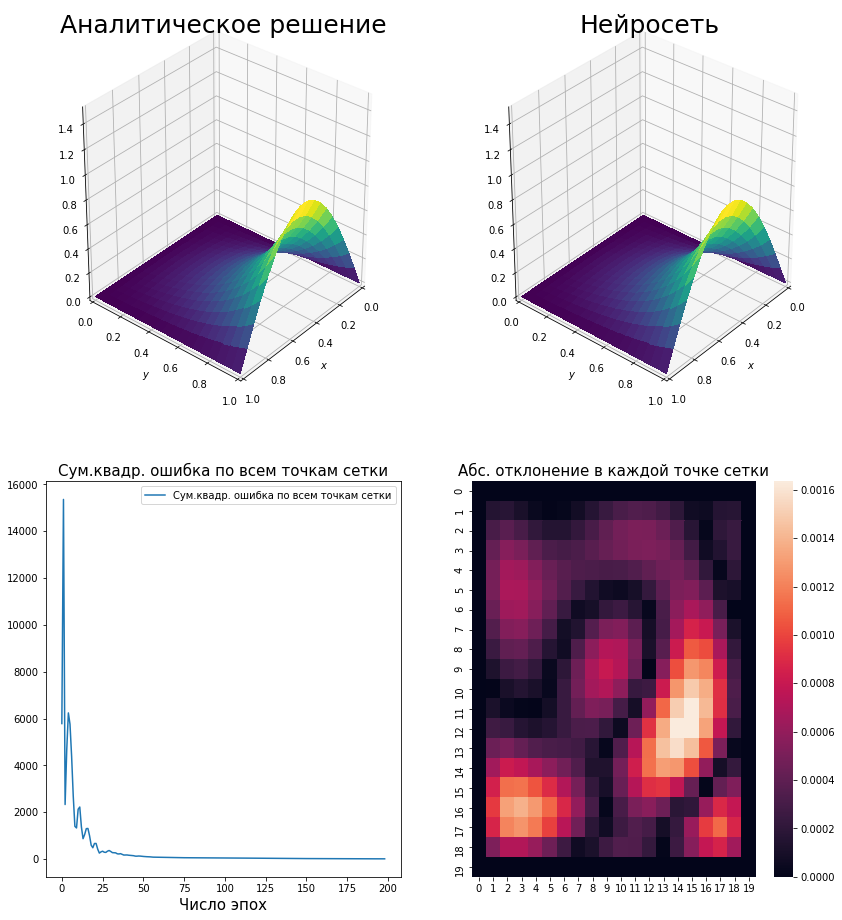

In [6]:
losses = train(NetSimpleGrad, N=20, lr=1, num_epoch=200, psy_trial=psy_trial1, A=A1, analytic_solution=analytic_solution1, 
               lim_x=1, lim_y=1, lim_z_low=0, path_to_images='Task1', hidden_size=20, use_schedule=False, angle=40)

### Task 21

$$ \begin{equation*} 
\begin{cases} \frac{\partial u^2}{\partial x^2} + \frac{\partial u^2}{\partial y^2} = 0,\\
u(x,0) = sin(\pi x),\\
u(x,1) = 0, \\
u(0,y) = sin(\pi y), \\
 u(1,y) = 0, \\
 0 \leqslant x \leqslant 1, 0 \leqslant y \leqslant 1.
\end{cases} 
\end{equation*}
$$


$$ \psi_{trial} = A(x,y) + x(1-x)y(1-y) * netOutput, $$
$$ A(x,y) = (1-x) sin(\pi y) + (1-y) sin(\pi x), $$
$$ AnalyticSolution(x,y) = \frac{sin \left( \pi x \right) sinh \left( \pi (1 - y) \right)}{sinh(\pi)} + \frac{sin \left( \pi y \right) sinh \left( \pi (1 - x) \right)}{sinh(\pi)}. $$

In [7]:
def A_21(x):
  return (1 - x[0]) * torch.sin(np.pi * x[1]) + (1 - x[1]) * torch.sin(np.pi * x[0])

def psy_trial_21(x, net_out):
  return A_21(x) + x[0] * (1 - x[0]) * x[1] * (1 - x[1]) * net_out

def analytic_solution_21(x):
  return (np.sin(np.pi * x[0]) * np.sinh(np.pi * (1 - x[1])) / np.sinh(np.pi)) + (np.sin(np.pi * x[1]) * np.sinh(np.pi * (1 - x[0])) / np.sinh(np.pi))

149 13.200302124023438


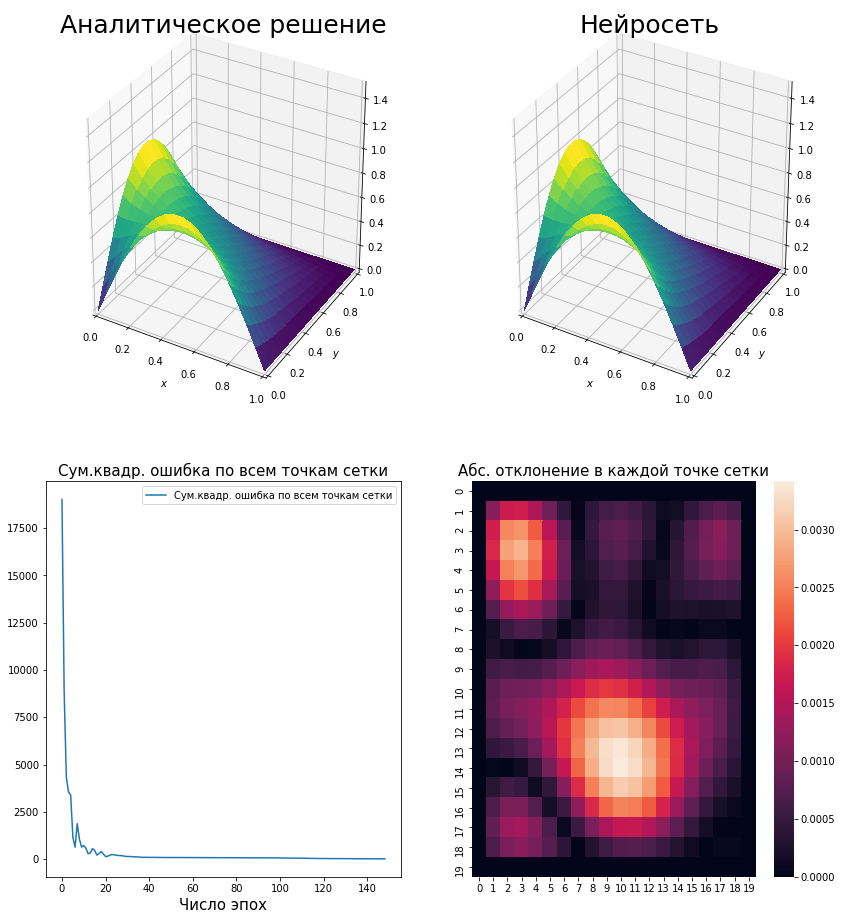

In [8]:
losses = train(NetSimpleGrad, N=20, lr=1, num_epoch=150, psy_trial=psy_trial_21, A=A_21, analytic_solution=analytic_solution_21,
               lim_x=1, lim_y=1, lim_z_low=0, path_to_images='Task21', hidden_size=20, use_schedule=False, angle=-60)

### Task 22

$$ \begin{equation*} 
\begin{cases} \frac{\partial u^2}{\partial x^2} + \frac{\partial u^2}{\partial y^2} = 0,\\
u(x,0) = sin \left( \frac{\pi x}{a} \right),\\
u(x,b) = sin \left( \frac{2 \pi x}{a} \right), \\
u(0,y) = 0, \\
 u(a,y) = 0, \\
 0 \leqslant x \leqslant a, 0 \leqslant y \leqslant b.
\end{cases} 
\end{equation*}
$$


$$ \psi_{trial} = A(x,y) + x(a-x)y(b-y) * netOutput, $$
$$ A(x,y) = \left[ sin(\frac{2 \pi x}{a}) - sin(\frac{\pi x}{a}) \right] \frac{y}{b} + sin(\frac{\pi x}{a}). $$

$$ AnalyticSolution(x,y) = \frac{\sin \left( \pi x \right)  \sinh \left( \frac{\pi (b - y)}{a} \right) }{\sinh \left( \frac{\pi b}{a} \right) } + 
\frac{\sin \left( \frac{2 \pi x}{a} \right)  \sinh \left( \frac{2 \pi y}{a} \right) }{\sinh(\frac{2 \pi b}{a})}. $$

$$ \text{Assume } a = 3, b = 2. $$

In [9]:
### Task 22
a = 3
b = 2
def A_22(x):
  return ((b - x[1]) / b) * torch.sin(np.pi * x[0] / a) + (x[1] / b ) * torch.sin(2 * np.pi * x[0] / a)

def psy_trial_22(x, net_out):
  return A_22(x) + x[0] * (x[0] - a) * x[1] * (x[1] - b) * net_out

def analytic_solution_22(x):
  return (np.sin(np.pi * x[0] / a) * np.sinh(np.pi * (b - x[1]) / a) / np.sinh(np.pi * b / a)) + (np.sin(2* np.pi * x[0] / a) * np.sinh(2 * np.pi * x[1] / a) / np.sinh(2 * np.pi * b / a))

149 57.96842575073242


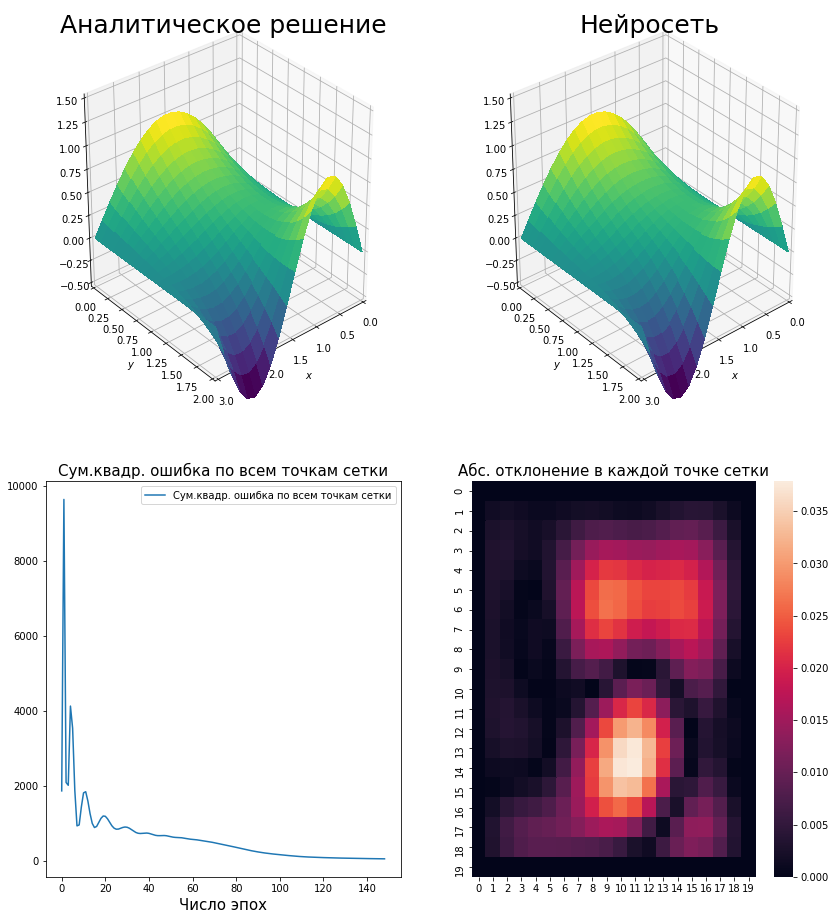

In [10]:
losses = train(NetSimpleGrad, N=20, lr=0.1, num_epoch=150, psy_trial=psy_trial_22, A=A_22, 
               analytic_solution=analytic_solution_22,
               lim_x=a, lim_y=b, lim_z_low=-0.5, path_to_images='Task22', angle=50)

### Task Combined

$$ \begin{equation*} 
\begin{cases} \frac{\partial u^2}{\partial x^2} + \frac{\partial u^2}{\partial y^2} = 0,\\
u(x,0) = sin \left( \frac{\pi x}{a} \right),\\
u(x,b) = sin \left( \frac{3 \pi x}{a} \right), \\
u(0,y) = 0, \\
 u(a,y) = 0, \\
 0 \leqslant x \leqslant a, 0 \leqslant y \leqslant b.
\end{cases} 
\end{equation*}
$$


$$ \psi_{trial} = A(x,y) + x(a-x)y(b-y) * netOutput, $$
$$ A(x,y) = \left[ sin(\frac{3 \pi x}{a}) - sin(\frac{\pi x}{a}) \right] \frac{y}{b} + sin(\frac{\pi x}{a}). $$

$$ AnalyticSolution(x,y) = \frac{\sin \left( \pi x \right)  \sinh \left( \frac{\pi (b - y)}{a} \right) }{\sinh \left( \frac{\pi b}{a} \right) } + 
\frac{\sin \left( \frac{3 \pi x}{a} \right)  \sinh \left( \frac{3 \pi y}{a} \right) }{\sinh(\frac{3 \pi b}{a})}. $$

$$ \text{Assume } a = 1, b = 2. $$

In [11]:
a = 1
b = 2
def A_combined_t(x):
  return (torch.sin(3 * np.pi * x[0] / a) - torch.sin(2 * np.pi * x[0] / a)) / b * x[1] + torch.sin(2 * np.pi * x[0] / a)

def psy_trial_combined_t(x, net_out):
  return A_combined_t(x) + x[0] * (x[0] - a) * x[1] * (x[1] - b) * net_out

def analytic_solution_combined_t(x):
  return (np.sin(2 * np.pi * x[0] / a) * np.sinh(2 * np.pi * (b - x[1]) / a) / np.sinh(2*np.pi * b / a)) + (np.sin(3 * np.pi * x[0] / a) * np.sinh(3 * np.pi * x[1] / a) / np.sinh(3 * np.pi * b / a))

399 22743.658203125


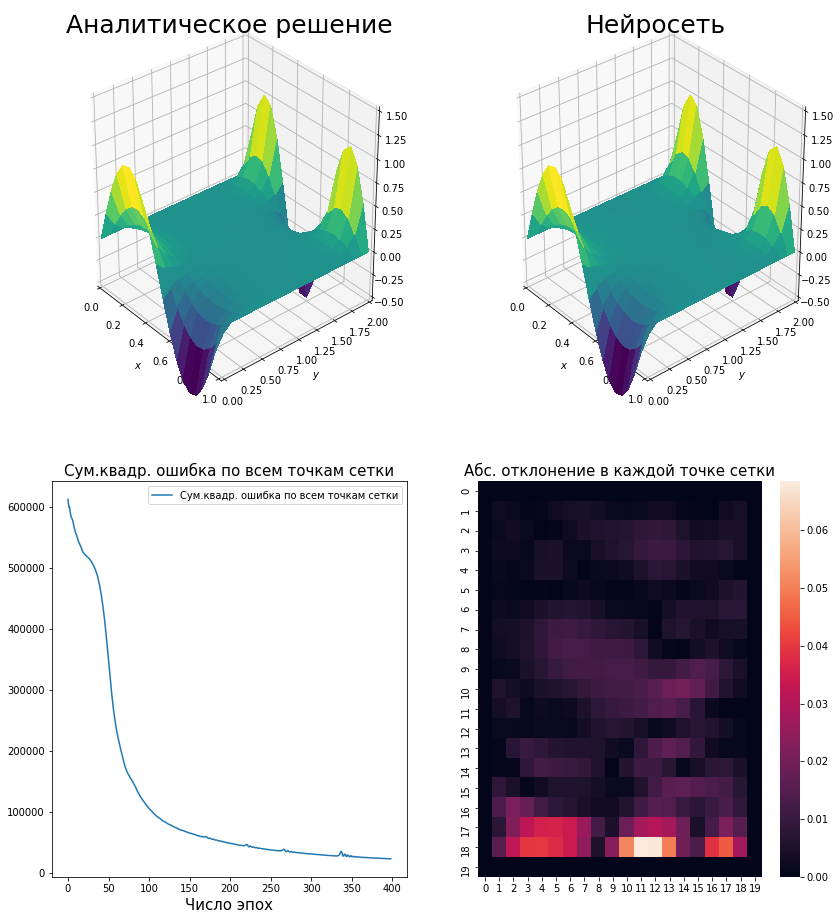

In [12]:
losses = train(NetSimpleGrad, N=20, lr=0.1, num_epoch=400, 
               psy_trial=psy_trial_combined_t, A=A_combined_t, analytic_solution=analytic_solution_combined_t,
               lim_x=a, lim_y=b, lim_z_low=-0.5, path_to_images='TaskCombined', hidden_size=100, use_schedule=False, angle=-40)

### Combined_three

$$ \begin{equation*} 
\begin{cases} \frac{\partial u^2}{\partial x^2} + \frac{\partial u^2}{\partial y^2} = 0,\\
u(x,0) = sin \left( \frac{\pi x}{a} \right),\\
u(x,b) = sin \left( \frac{2 \pi x}{a} \right), \\
u(0,y) = sin \left( \frac{3 \pi y}{b} \right), \\
 u(a,y) = 0, \\
 0 \leqslant x \leqslant a, \\
 0 \leqslant y \leqslant b.
\end{cases} 
\end{equation*}
$$



$$ \psi_{trial} = A(x,y) + x(a-x)y(b-y) * netOutput, $$
$$ A(x,y) = \frac{a - x}{a} sin \left( \frac{3 \pi y}{b} \right) + \frac{b-y}{b} sin \left( \frac{\pi x}{a} \right) + \frac{y}{b} sin \left( \frac{2 \pi x}{a} \right), $$

$$ AnalyticSolution(x,y) = \frac{\sin \left( \frac{\pi x}{a} \right)  \sinh \left( \frac{\pi (b - y)}{a} \right) }{\sinh \left( \frac{\pi b}{a} \right) } + 
\frac{\sin \left( \frac{2 \pi x}{a} \right)  \sinh \left( \frac{2 \pi y}{a} \right) }{\sinh \left( \frac{2 \pi b}{a} \right) } + \frac{\sin \left( \frac{3 \pi y}{b} \right)  \sinh \left( \frac{3 \pi (a - x)}{b} \right) }{\sinh \left( \frac{3 \pi a}{b} \right) }.$$

$$ \text{Assume } a = 1, b = 1. $$

In [13]:
a = 1
b = 1
def A_combined_three(x):
  return ((a - x[0]) / a) * torch.sin(3 * np.pi * x[1] / b) + ((b - x[1]) / b) * torch.sin(np.pi * x[0] / a) +\
   (x[1] / b) * torch.sin(2 * np.pi * x[0] / a)
def psy_trial_combined_three(x, net_out):
  return A_combined_three(x) + x[0] * (x[0] - a) * x[1] * (x[1] - b) * net_out

def analytic_solution_combined_three(x):
  return np.sin(np.pi * x[0] / a) * np.sinh(np.pi * (b - x[1]) / a) / np.sinh(np.pi * b / a) +\
  (np.sin(2* np.pi * x[0] / a) * np.sinh(2 * np.pi * x[1] / a) / np.sinh(2 * np.pi * b / a)) +\
  (np.sin(3 * np.pi * x[1] / b) * np.sinh(3 * np.pi * (a - x[0]) / b) / np.sinh(3 * np.pi * a / b))

399 1955.3135986328125


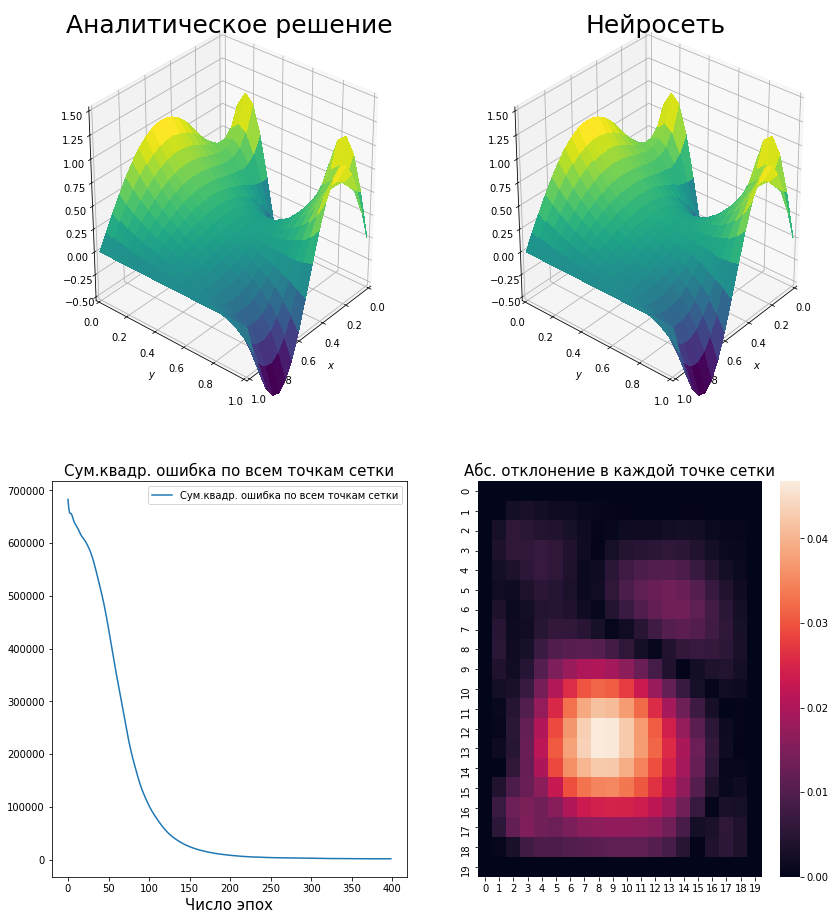

In [14]:
losses = train(NetSimpleGrad, N=20, lr=0.1, num_epoch=400, 
               psy_trial=psy_trial_combined_three, A=A_combined_three, analytic_solution=analytic_solution_combined_three,
               lim_x=a, lim_y=b, lim_z_low=-0.5, path_to_images='TaskCombinedThree', 
               hidden_size=100, use_schedule=False)

### Combined four

$$ \begin{equation*} 
\begin{cases} \frac{\partial u^2}{\partial x^2} + \frac{\partial u^2}{\partial y^2} = 0,\\
u(x,0) = sin \left( \frac{\pi x}{a} \right),\\
u(x,1) = sin \left( \frac{2 \pi x}{a} \right), \\
u(0,y) = sin \left( \frac{3 \pi y}{b} \right), \\
 u(1,y) = sin \left( \frac{4 \pi y}{b} \right), \\
 0 \leqslant x \leqslant a, \\
 0 \leqslant y \leqslant b.
\end{cases} 
\end{equation*}
$$


$$ \psi_{trial} = A(x,y) + x(a-x)y(b-y) * netOutput, $$
$$ A(x,y) = \frac{a - x}{a} sin \left( \frac{3 \pi y}{b} \right) + \frac{b-y}{b} sin \left( \frac{\pi x}{a} \right) + \frac{y}{b} sin \left( \frac{2 \pi x}{a} \right) + \frac{x}{a} sin \left( \frac{4 \pi y}{b} \right), $$

$$ AnalyticSolution(x,y) = \frac{\sin \left( \frac{\pi x}{a} \right)  \sinh \left( \frac{\pi (b - y)}{a} \right) }{\sinh \left( \frac{\pi b}{a} \right) } + 
\frac{\sin \left( \frac{2 \pi x}{a} \right)  \sinh \left( \frac{2 \pi y}{a} \right) }{\sinh \left( \frac{2 \pi b}{a} \right) } + \frac{\sin \left( \frac{3 \pi y}{b} \right)  \sinh \left( \frac{3 \pi (a - x)}{b} \right) }{\sinh \left( \frac{3 \pi a}{b} \right) } + \frac{\sin \left( \frac{4 \pi y}{b} \right)  \sinh \left( \frac{\pi (a - x)}{b} \right)}{\sinh \left( \frac{4 \pi a}{b} \right)}.$$

$$ \text{Assume } a = 2, b = 1. $$

In [15]:
a = 2
b = 1
def A_combined_four_ab(x):
  return ((a - x[0]) / a) * torch.sin(3 * np.pi * x[1] / b) + ((b - x[1]) / b) * torch.sin(np.pi * x[0] / a) +\
   (x[1] / b) * torch.sin(2 * np.pi * x[0] / a) + (x[0] / a) * torch.sin(4 * np.pi * x[1] / b)

def psy_trial_combined_four_ab(x, net_out):
  return A_combined_four_ab(x) + x[0] * (x[0] - a) * x[1] * (x[1] - b) * net_out

def analytic_solution_combined_four_ab(x):
  return np.sin(np.pi * x[0] / a) * np.sinh(np.pi * (b - x[1]) / a) / np.sinh(np.pi * b / a) +\
  (np.sin(2* np.pi * x[0] / a) * np.sinh(2 * np.pi * x[1] / a) / np.sinh(2 * np.pi * b / a)) +\
  (np.sin(3 * np.pi * x[1] / b) * np.sinh(3 * np.pi * (a - x[0]) / b) / np.sinh(3 * np.pi * a / b)) +\
  (np.sin(4 * np.pi * x[1] / b) * np.sinh(4 * np.pi * x[0] / b) / np.sinh(4 * np.pi * a / b))

399 226606.125


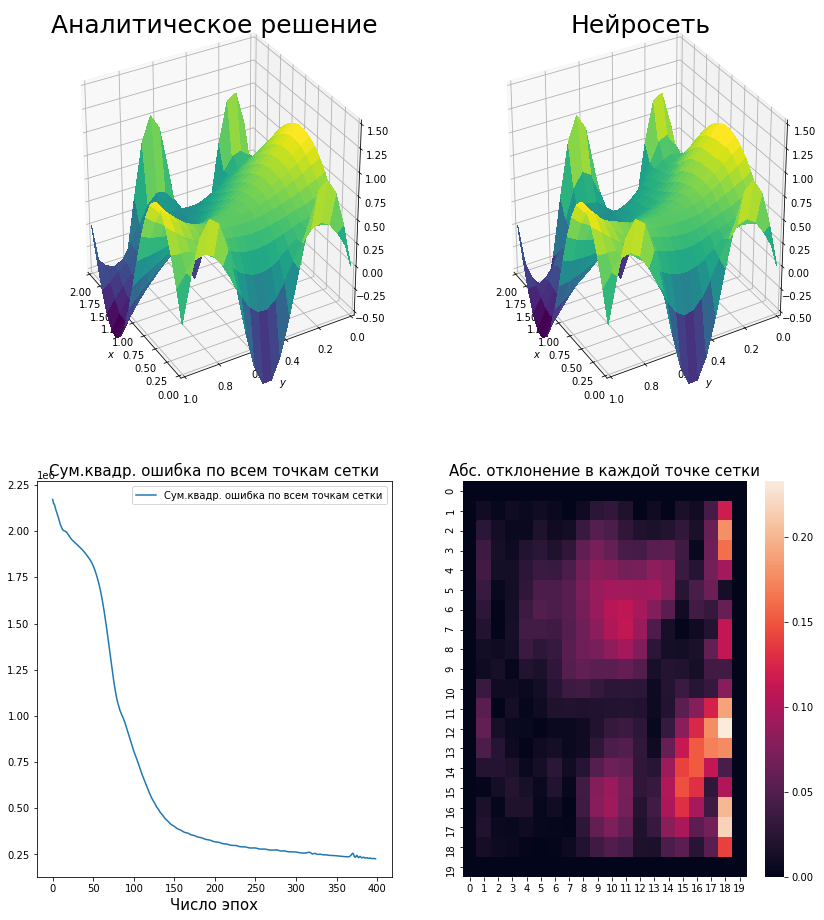

In [16]:
losses = train(NetSimpleGrad, N=20, lr=0.1, num_epoch=400, 
               psy_trial=psy_trial_combined_four_ab, A=A_combined_four_ab, analytic_solution=analytic_solution_combined_four_ab,
               lim_x=a, lim_y=b, lim_z_low=-0.5, path_to_images='TaskCombinedFour', 
               hidden_size=100, angle=360 - (-160 + 20) + 10, use_schedule=False, schedule_ep=150, schedule_gamma=0.5, 
               create_gif=True, fps=10)